## For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.|

In [3]:
!pip install wikipedia

  Stored in directory: /home/dsxuser/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [4]:
!pip install folium

     |████████████████████████████████| 102kB 9.9MB/s eta 0:00:01


In [23]:
!pip install shapely

     |████████████████████████████████| 1.8MB 12.6MB/s eta 0:00:01


In [26]:
!pip install geopandas

     |████████████████████████████████| 931kB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 7.0MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 15.6MB/s eta 0:00:01


In [42]:
import pandas as pd 
import wikipedia as wp
from bs4 import BeautifulSoup

import requests
import io

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from shapely.geometry import Point
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import matplotlib.pyplot as plt

# setup import
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [6]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")

In [7]:
# determine the index of your table
df = pd.read_html(html, header = 0)[0]

In [8]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [16]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [10]:
df.loc[df.Neighborhood == 'Not assigned']

,Postal Code,Borough,Neighborhood


In [17]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

df.Neighborhood.replace('Not assigned',df.Borough,inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [18]:
#Group Neighbourhoods with the same Postcode

df_toronto = df.groupby(['Postal Code', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x))
df_toronto = df_toronto.reset_index()
df_toronto.rename(columns = {'Postal Code':'Postal Code'}, inplace = True)
df_toronto.rename(columns = {'Neighborhood':'Neighborhood'}, inplace = True)
df_toronto.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [13]:
df_toronto.shape

(103, 3)

In [19]:
# in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.
url="http://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))
c.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
# rename the first column to allow merging dataframes on Postcode
c.columns = ['Postal Code', 'Latitude', 'Longitude']
df_ll = pd.merge(c, df_toronto, on='Postal Code')

# reorder column names and show the dataframe
df_ll = df_ll[['Postal Code', 'Borough', 'Neighborhood', 'Latitude', 'Longitude']]
df_ll.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [46]:
# load latitude and longitude into geopandas dataframe
df_ll['Coordinates'] = list(zip(df_ll.Longitude, df_ll.Latitude))
df_ll['Coordinates'] = df_ll['Coordinates'].apply(Point)
gdf = gpd.GeoDataFrame(df_ll, geometry='Coordinates')
df_ll.head(4)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Coordinates
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,POINT (-79.19435 43.80669)
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,POINT (-79.16050 43.78454)
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,POINT (-79.18871 43.76357)
3,M1G,Scarborough,Woburn,43.770992,-79.216917,POINT (-79.21692 43.77099)


/opt/conda/envs/Python36/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


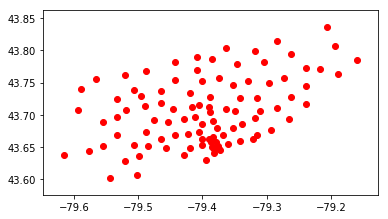

In [47]:
# set up map
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
ax = cities[cities.name == "Toronto"].plot(
    color='white', edgecolor='black')

# plot and show
gdf.plot(ax=ax, color='red')
plt.show()